In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE

In [ ]:
# rule-based function for bill amount imputation
# impute bill amount with previous payment when not delay
def impute_bill_amt(df, month_num):
    next_month_num = month_num + 1
    df[f'bill_amount_month{month_num}'] = \
          np.where((df[f'bill_amount_month{month_num}'].isnull()) & (df[f'payment_delay_month{month_num}(larger value means longer delay)'] <= 0),
          df[f'previous_payment_month{next_month_num}'],
          df[f'bill_amount_month{month_num}'])       

    return df


In [ ]:
# import raw data
df_train_raw = pd.read_csv('train.csv')
df_test_raw = pd.read_csv('test.csv')

df_train = df_train_raw.copy()
df_test= df_test_raw.copy()

df_train = df_train.set_index('id')
df_test = df_test.set_index('id')


# Preprocess

In [ ]:
# data cleaning (typo "unviersity")
df_train['education_level'] = df_train['education_level'].apply(lambda x: 'university' if x == 'unviersity' else x) 
df_test['education_level'] = df_test['education_level'].apply(lambda x: 'university' if x == 'unviersity' else x) 

# set 'age' abnormal data to nan
df_train['age'] = df_train['age'].apply(lambda x: None if x == 0 or x == 255 else x) 
df_test['age'] = df_test['age'].apply(lambda x: None if x == 0 or x == 255 else x) 


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22780 entries, 0 to 24107
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   credit_limit                                           22780 non-null  float64
 1   gender                                                 22609 non-null  object 
 2   education_level                                        22606 non-null  object 
 3   marital_status                                         22601 non-null  object 
 4   age                                                    22385 non-null  float64
 5   payment_delay_month4(larger value means longer delay)  22755 non-null  float64
 6   payment_delay_month3(larger value means longer delay)  22726 non-null  float64
 7   payment_delay_month2(larger value means longer delay)  22755 non-null  float64
 8   payment_delay_month1(larger value means longer

In [ ]:
# % of missing data in columns
print(df_train.isnull().sum()/ len(df_train))

credit_limit                                             0.000000
gender                                                   0.007507
education_level                                          0.007638
marital_status                                           0.007858
age                                                      0.017340
payment_delay_month4(larger value means longer delay)    0.001097
payment_delay_month3(larger value means longer delay)    0.002371
payment_delay_month2(larger value means longer delay)    0.001097
payment_delay_month1(larger value means longer delay)    0.004522
bill_amount_month4                                       0.020061
bill_amount_month3                                       0.028490
bill_amount_month2                                       0.025549
bill_amount_month1                                       0.026251
previous_payment_month4                                  0.001097
previous_payment_month3                                  0.001712
previous_p

In [ ]:
# descriptive statistics of columns
print(df_train.describe())

       credit_limit           age  \
count  2.278000e+04  22385.000000   
mean   1.256767e+05     35.392852   
std    1.209143e+05      9.152433   
min    2.850037e+03     21.000000   
25%    2.927165e+04     28.000000   
50%    8.806776e+04     34.000000   
75%    1.774701e+05     41.000000   
max    1.134620e+06     75.000000   

       payment_delay_month4(larger value means longer delay)  \
count                                       22755.000000       
mean                                            0.938255       
std                                             1.094109       
min                                            -1.000000       
25%                                             0.000000       
50%                                             1.000000       
75%                                             1.000000       
max                                             9.000000       

       payment_delay_month3(larger value means longer delay)  \
count                    

# Exploratory Data Analysis

0    0.825066
1    0.174934
Name: label_month5_payment, dtype: float64


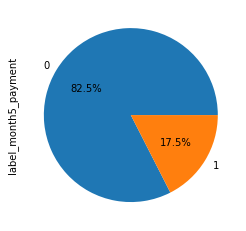

In [ ]:
# % of label
print(df_train['label_month5_payment'].value_counts()/len(df_train))

pie_data = df_train['label_month5_payment'].value_counts()
pie_data.plot.pie(y='label_month5_payment', autopct="%.1f%%")
plt.show()

**Imbalance data** need to be resampled before machine learning.

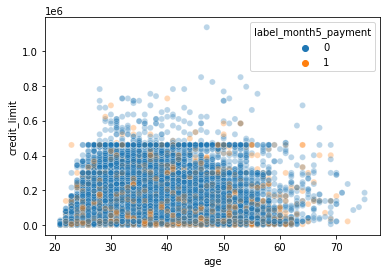

In [ ]:
sns.scatterplot(x='age', y='credit_limit', data=df_train, hue='label_month5_payment', alpha=.3)
plt.show()

Not so many label 1 in the **high credit limit** range

In [ ]:
print('Overall % Label "1": ', df_train['label_month5_payment'].mean().round(4))

Overall % Label "1":  0.1749


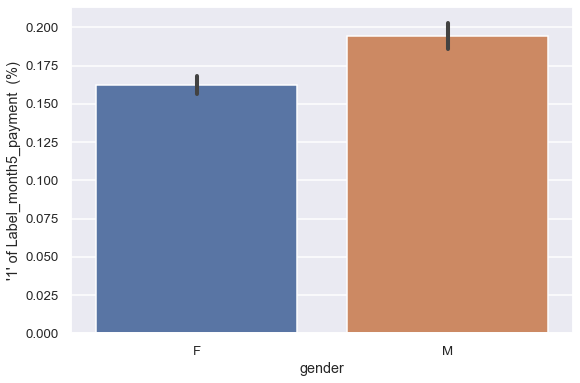

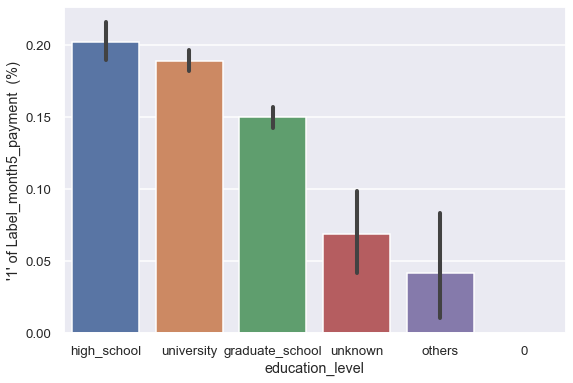

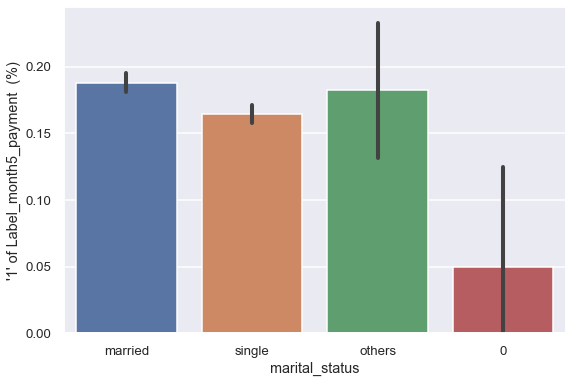

In [ ]:
# visualization of categorical columns
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

sns.set(rc={'figure.figsize':(9,6)})
sns.set_context("talk", font_scale=0.8)

for col in cat_cols:
    sns.barplot(x=col, y='label_month5_payment', data=df_train)
    plt.ylabel("'1' of Label_month5_payment  (%)")
    plt.show()

**Education level** and label 1 shows negative correlation

Distribution of Numeric Features by the Target Feature


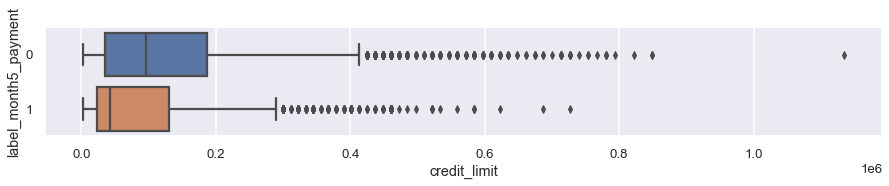

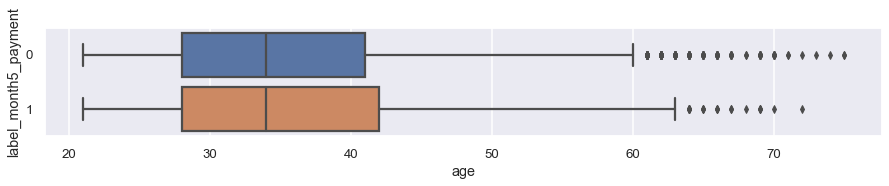

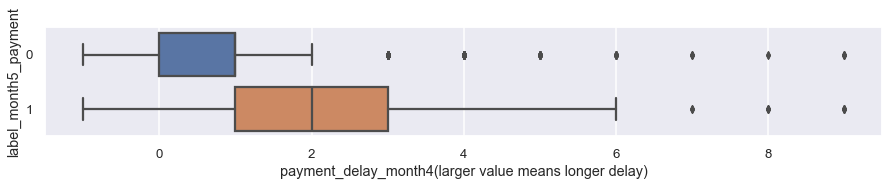

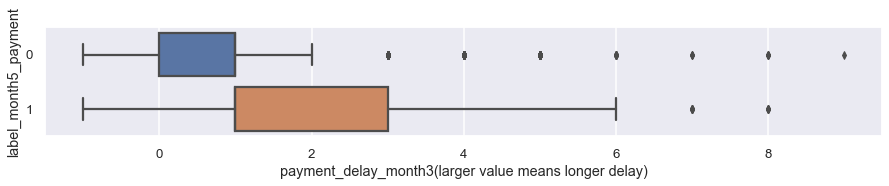

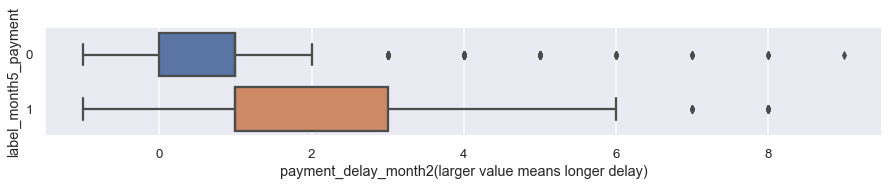

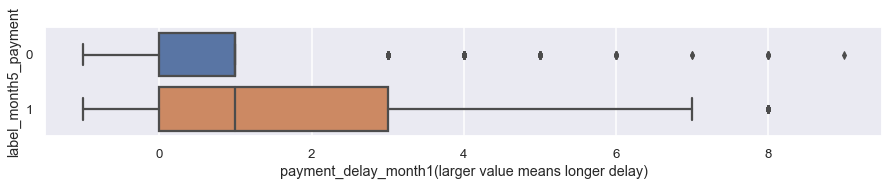

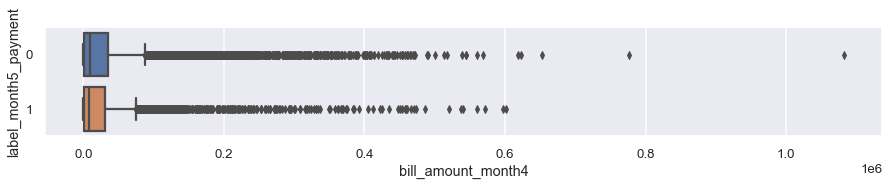

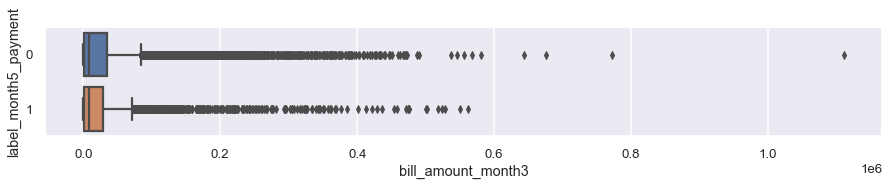

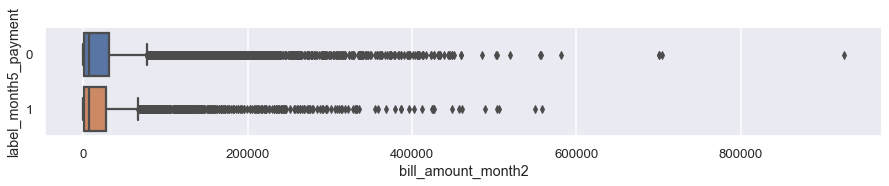

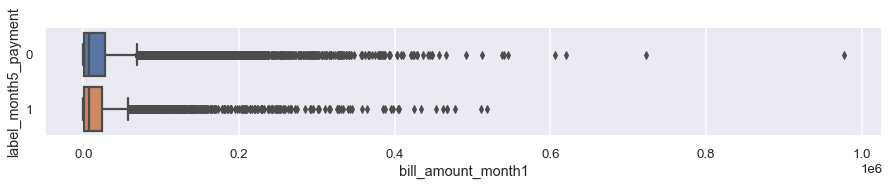

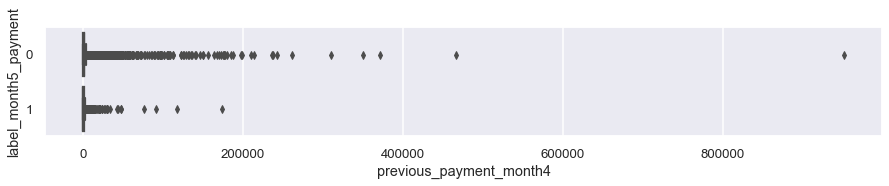

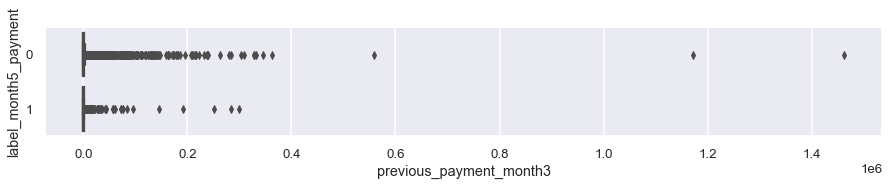

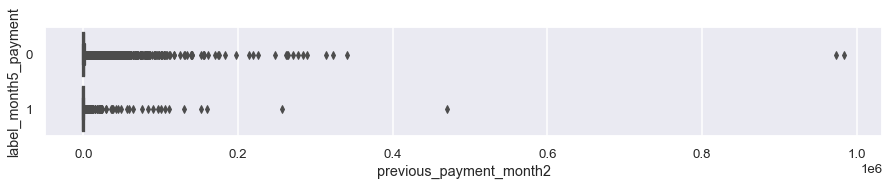

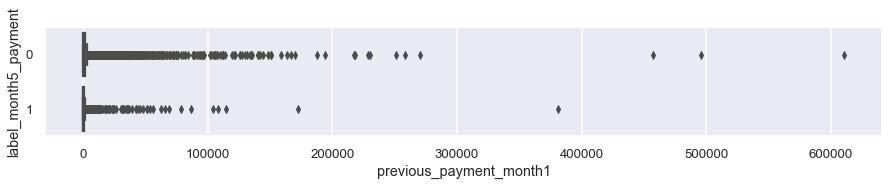

In [ ]:
# visualization of numeric columns
num_cols = df_train.select_dtypes(include=['float64']).columns.tolist()

sns.set(rc={'figure.figsize':(15,2)})
sns.set_context("talk", font_scale=0.8)

print('Distribution of Numeric Features by the Target Feature')
for col in num_cols:
    sns.boxplot(x=col, y="label_month5_payment", data=df_train, orient = 'h')
    plt.show()

In general, **credit_limit**, **payment_delay**, and **previous_payment** are stronger predictors than **bill_amount**.

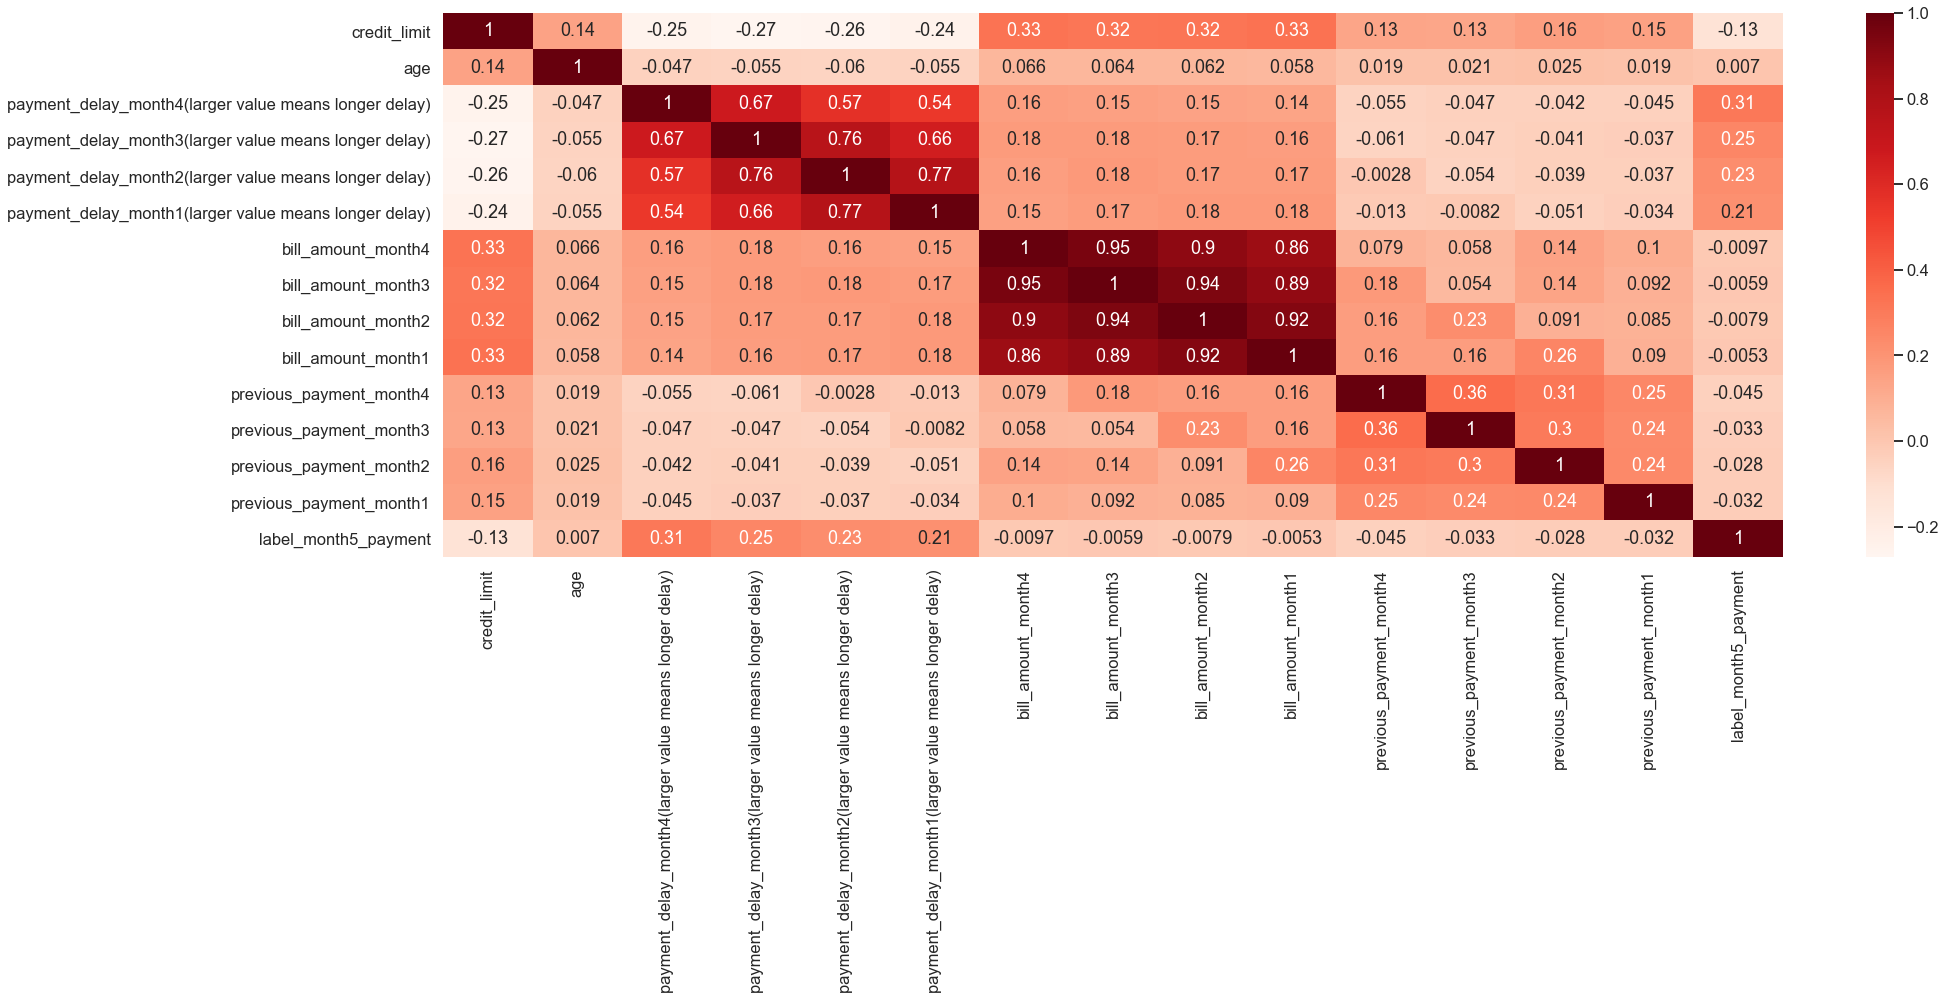

In [ ]:
# heatmap
sns.set(rc={'figure.figsize':(30,10)})
sns.set_context("talk", font_scale=1)

sns.heatmap(df_train.corr(), cmap='Reds', annot=True)
plt.show()

Among all features, **payment_delay_month4** is the most relevant to label_month5_payment, with a correlation of 0.31 (moderate relevance).

# Machine Learning 
### Logistic Regression vs. XGBoost

In [ ]:
# feature engineering

# impute bill amount with previous payment when not delay
df_train = impute_bill_amt(df_train,month_num=3)
df_train = impute_bill_amt(df_train,month_num=2)
df_train = impute_bill_amt(df_train,month_num=1)

df_test = impute_bill_amt(df_test,month_num=3)
df_test = impute_bill_amt(df_test,month_num=2)
df_test = impute_bill_amt(df_test,month_num=1)

# fill missing data with the mean of training set (avoid data leakage)
df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_train.mean()) 


In [ ]:
# split X, y 
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]


X_test = df_test.iloc[:,:-1]

In [ ]:
# add age_range
X_train['age_range'] = pd.cut(X_train['age'], bins=5)
X_test['age_range'] = pd.cut(X_test['age'], bins=5)

# one-hot encoing
cat_features = ['gender', 'education_level', 'marital_status', 'age_range']

X_train = pd.get_dummies(data=X_train, columns=cat_features)
X_test = pd.get_dummies(data=X_test, columns=cat_features)


In [ ]:
# resample for imbalance data
method = SMOTE(random_state=100)
X_train_resampled, y_train_resampled= method.fit_resample(X_train, y_train)


#### Logistic Regression

In [ ]:
# base model: set up LR Pipeline & GridSearch
lr_pipeline = Pipeline(steps=[("st_scaler", StandardScaler()),
                              ("lr_model",LogisticRegression( random_state = 100))])

param_grid_lr = {
                'lr_model__C': [0.1, 1, 10]
                }

grid_search_roc_lr = GridSearchCV(estimator= lr_pipeline, 
                                    param_grid= param_grid_lr, 
                                    scoring='roc_auc',
                                    cv=5,
                                    refit=True,
                                    n_jobs = -1)  


In [ ]:
# fit base model and print results
grid_search_roc_lr.fit(X_train_resampled, y_train_resampled)
print(grid_search_roc_lr.best_params_)
print('Best ROC AUC: ', grid_search_roc_lr.best_score_)


{'lr_model__C': 0.1}
Best ROC AUC:  0.9195495057671644


#### XGBoost

In [ ]:
# set up XGBoost Pipeline & GridSearch

xgb_pipeline = Pipeline(steps=[("st_scaler", StandardScaler()), 
                               ("xgb_model",xgb.XGBClassifier(objective='binary:logistic', 
                                                              random_state = 100, 
                                                              verbosity = 0,
                                                              use_label_encoder =False))])
# hyperparameter tuning
param_grid = { 'xgb_model__n_estimators': [200, 300],
               'xgb_model__max_depth': [4, 5],
               'xgb_model__subsample': [0.8, 0.9],
               'xgb_model__colsample_bytree': [0.8, 0.9],
               'xgb_model__learning_rate': [0.05, 0.1],
               'xgb_model__gamma': [0.2, 0.5]
               }  


grid_search_roc = GridSearchCV(estimator= xgb_pipeline, 
                                    param_grid= param_grid, 
                                    scoring='roc_auc',
                                    cv=5,
                                    refit=True,
                                    n_jobs = -1)  


In [ ]:
# fit XGBoost with training set
grid_search_roc.fit(X_train_resampled, y_train_resampled)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('st_scaler', StandardScaler()),
                                       ('xgb_model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                         

In [ ]:
# print results
print(grid_search_roc.best_params_)
print('Best ROC AUC: ', grid_search_roc.best_score_)

# extract best model pipeline
xgbc_best = grid_search_roc.best_estimator_


{'xgb_model__colsample_bytree': 0.8, 'xgb_model__gamma': 0.2, 'xgb_model__learning_rate': 0.05, 'xgb_model__max_depth': 5, 'xgb_model__n_estimators': 300, 'xgb_model__subsample': 0.9}
Best ROC AUC:  0.9458085696748659


##### Since the model is fitted with resampled training data, we need to validate it on the **original training set**

In [ ]:
# model validation on training set
Pred_train = xgbc_best.predict(X_train)
Prob_train = xgbc_best.predict_proba(X_train)

Accuracy_train = xgbc_best.score(X_train, y_train)
print('Train set accuracy', Accuracy_train)

roc_auc_train = roc_auc_score(y_train, Prob_train[:,1])
print('Train set ROC AUC score: {:.4f}'.format(roc_auc_train))


Train set accuracy 0.856540825285338
Train set ROC AUC score: 0.8443


###### make prediction and save result

In [ ]:
# predict on test set
Pred = xgbc_best.predict(X_test)

# save result
df_pred = pd.DataFrame(Pred, columns= ['Prediction'])
df_test_raw['label_month5_payment'] = df_pred['Prediction']
df_test_raw.to_csv('result.csv', index=False)


###### feature importance

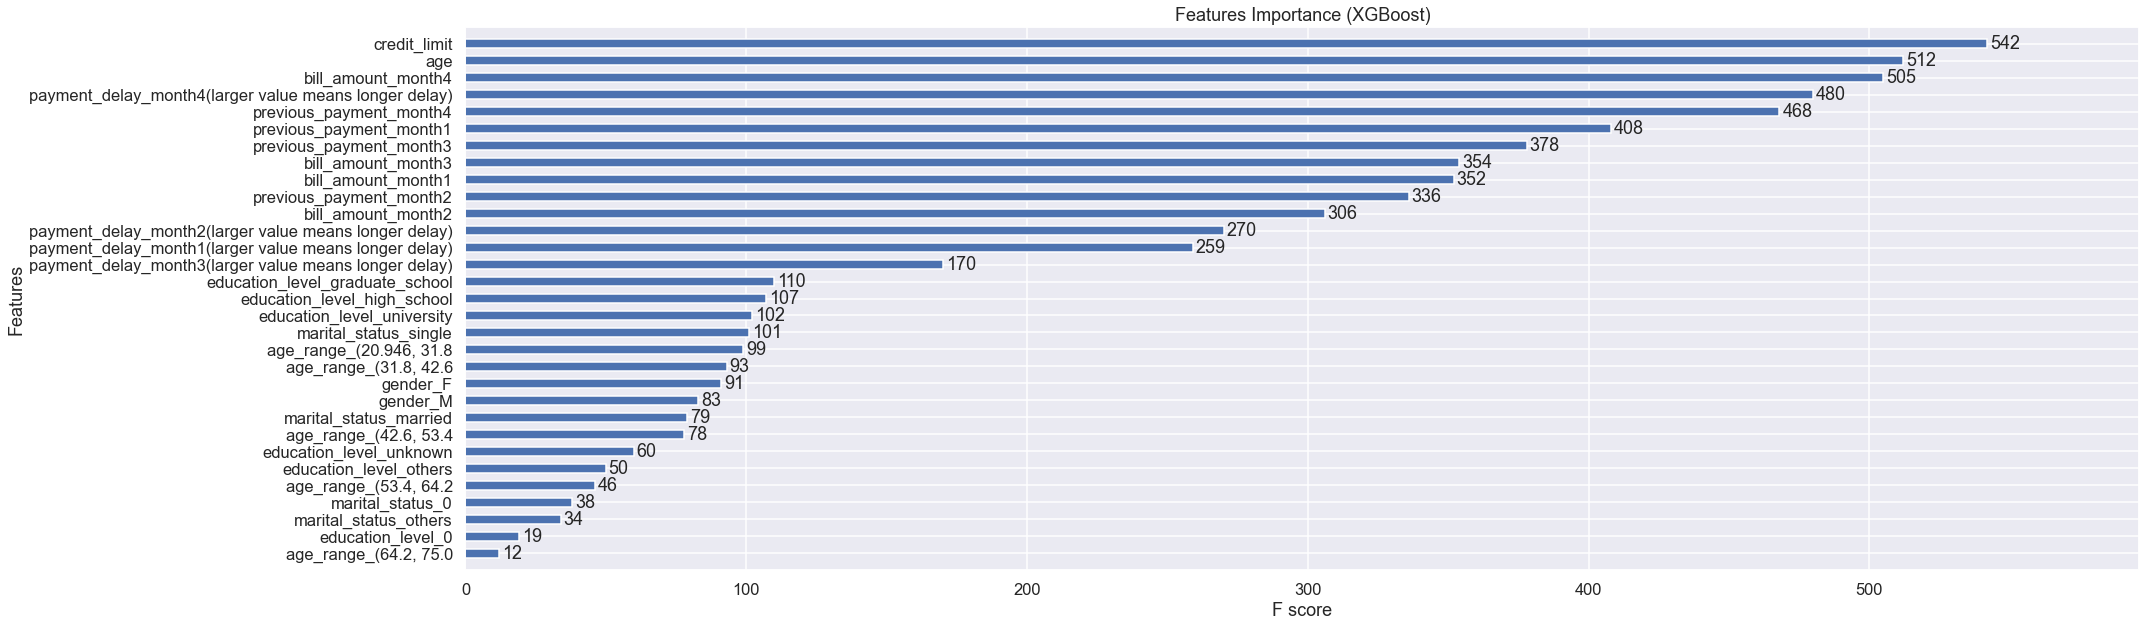

In [ ]:
# set feature names
grid_search_roc.best_estimator_.named_steps["xgb_model"].get_booster().feature_names = X_train.columns.tolist()
xgb.plot_importance(grid_search_roc.best_estimator_.named_steps["xgb_model"], 
                    title="Features Importance (XGBoost)",
                    height=0.5,
                    importance_type='weight')
plt.show() 
